In [2]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
# import geopandas as gpd

import cartopy
import matplotlib.pyplot as plt
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial
from plotter import draw_basemap, plot_terrain, plot_sensitivity_cbar
from trajectory import calculate_backward_trajectory
import customcmaps as ccmaps

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
## what was the starting pressure at the site for each of these storms?


In [4]:
HUC8_lst = [14050001, ## upper yampa
               14030002, ## upper dolores
               10190002, ## 'Upper South Platte'
               11020001 ## Arkansas Headwaters
              ]

HUC8_lbl = ['Upper Yampa', 'Upper Dolores', 'Upper South Platte', 'Arkansas Headwaters']
ds_lst = []
## loop through all HUC8s
for i, HUC8_ID in enumerate(HUC8_lst):
    fname = '/expanse/nfs/cw3e/cwp140/preprocessed/ERA5_trajectories/sensitivity_tests/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    ds = xr.open_dataset(fname)
    ds = ds.assign(grid=['center', 'east', 'north', 'south', 'west'])
    ds_lst.append(ds)

ds = xr.concat(ds_lst, pd.Index(HUC8_lst, name="HUC8"))
ds

/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:       (start_lev: 4, grid: 5, start_date: 40, index: 72, HUC8: 4)
Coordinates:
  * start_lev     (start_lev) float64 500.0 600.0 700.0 800.0
  * grid          (grid) <U6 'center' 'east' 'north' 'south' 'west'
  * start_date    (start_date) datetime64[ns] 2003-03-17 ... 2019-03-14T18:00:00
  * index         (index) int64 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
  * HUC8          (HUC8) int64 14050001 14030002 10190002 11020001
Data variables:
    time          (HUC8, start_lev, grid, start_date, index) datetime64[ns] 2...
    latitude      (HUC8, start_lev, grid, start_date, index) float64 40.45 .....
    longitude     (HUC8, start_lev, grid, start_date, index) float64 -107.1 ....
    level         (HUC8, start_lev, grid, start_date, index) float64 500.0 .....
    q             (HUC8, start_lev, grid, start_date, index) float64 1.349 .....
    u             (HUC8, start_lev, grid, start_date, index) float64 5.085 .....
    v             (HUC8, start_lev, grid, start_date, index) float64 8.518 .....
    w             (HUC8, start_lev, grid, start_date, index) float64 -0.3193 ...
    dq            (HUC8, start_lev, grid, start_date, index) float64 nan ... nan
    drying_ratio  (HUC8, start_lev, grid, start_date, index) float64 nan ... nan

In [5]:
## Load Basin watershed file
fp = '/expanse/nfs/cw3e/cwp140/downloads/UpperCo/Upper_Colorado_River_Basin_Boundary.shp'
basin = gpd.read_file(fp, crs="EPSG:4326") # have to manually set the projection
basin

idx = (polys.HUC8 == str(HUC8_lst[0])) | (polys.HUC8 == str(HUC8_lst[1])) | (polys.HUC8 == str(HUC8_lst[2])) | (polys.HUC8 == str(HUC8_lst[3]))
basin =  basin[idx]
basin

NameError: name 'gpd' is not defined

In [7]:
storm = 'mar2019'
if storm == 'mar2003':
    tmp = ds.sel(start_date=slice('2003-03-18 12', '2003-03-19 06'))
elif storm == 'mar2019':
    tmp = ds.sel(start_date=slice('2019-03-13 12', '2019-03-14  06'))
tmp

<xarray.Dataset>
Dimensions:       (start_lev: 4, grid: 5, start_date: 4, index: 72, HUC8: 4)
Coordinates:
  * start_lev     (start_lev) float64 500.0 600.0 700.0 800.0
  * grid          (grid) <U6 'center' 'east' 'north' 'south' 'west'
  * start_date    (start_date) datetime64[ns] 2019-03-13T12:00:00 ... 2019-03...
  * index         (index) int64 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
  * HUC8          (HUC8) int64 14050001 14030002 10190002 11020001
Data variables:
    time          (HUC8, start_lev, grid, start_date, index) datetime64[ns] 2...
    latitude      (HUC8, start_lev, grid, start_date, index) float64 40.45 .....
    longitude     (HUC8, start_lev, grid, start_date, index) float64 -107.1 ....
    level         (HUC8, start_lev, grid, start_date, index) float64 500.0 .....
    q             (HUC8, start_lev, grid, start_date, index) float64 1.875 .....
    u             (HUC8, start_lev, grid, start_date, index) float64 -4.404 ....
    v             (HUC8, start_lev, grid, start_date, index) float64 -0.3213 ...
    w             (HUC8, start_lev, grid, start_date, index) float64 -0.5054 ...
    dq            (HUC8, start_lev, grid, start_date, index) float64 nan ... nan
    drying_ratio  (HUC8, start_lev, grid, start_date, index) float64 nan ... nan

In [8]:
## create tick labels 'YYYY-MM-DD HH'
t_lst = []
for m, start_date_val in enumerate(tmp.start_date.values):
    ts = pd.to_datetime(str(start_date_val)) 
    t = ts.strftime('%Y-%m-%d %HZ')
    t_lst.append(t)
# ["{:.0%}".format(i) for i in cbax.get_ticks()]
t_lst

['2019-03-13 12Z', '2019-03-13 18Z', '2019-03-14 00Z', '2019-03-14 06Z']

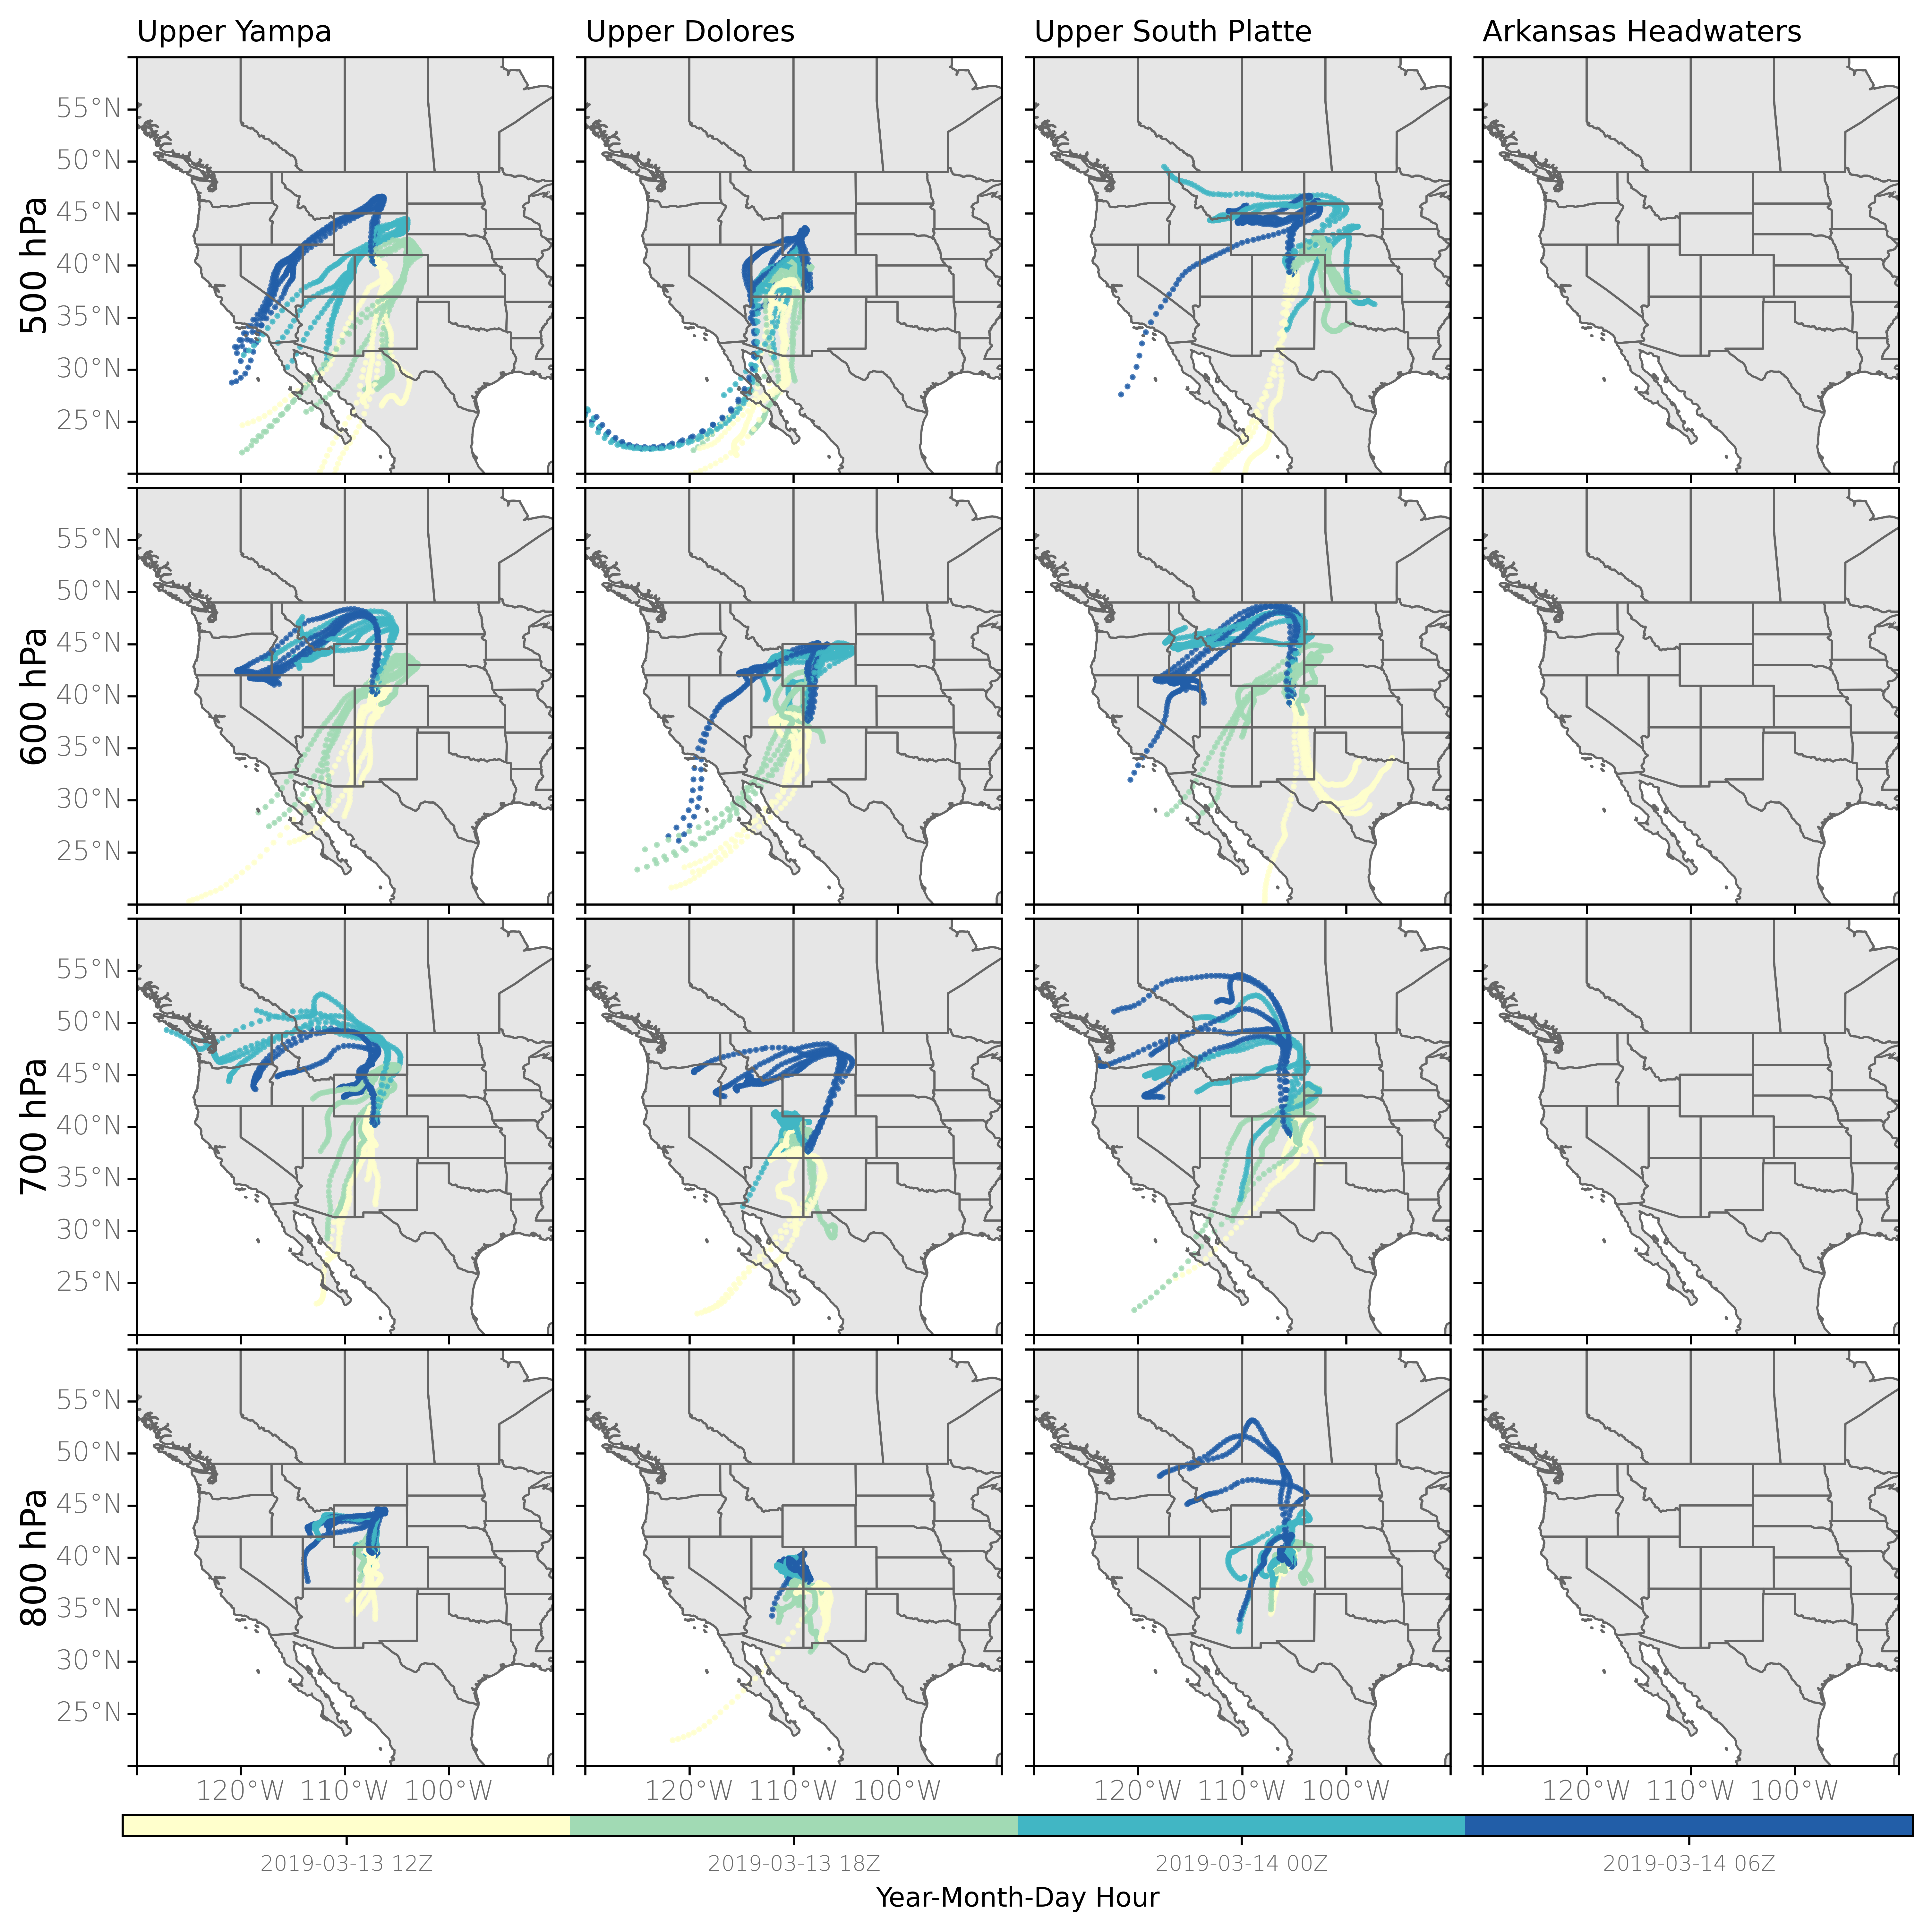

In [9]:
ext = [-130., -90., 20., 60.] 
fmt = 'png'
nrows = 6
ncols = 4
colors = ['#ffffcc', '#a1dab4', '#41b6c4', '#225ea8']

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

fig = plt.figure(figsize=(12.0 ,12.0))
fig.dpi = 600
fname = '../figs/sensitivity_test_trajectory_{0}'.format(storm)

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1, 0.05, 0.05], width_ratios = [1, 1, 1, 1], wspace=0.01, hspace=0.05)
## use gs[rows index, columns index] to access grids

left_lats = [True, False, False, False]
## each 6 hours gets its own plot
for i, HUC8 in enumerate(tmp.HUC8.values):
    for j, lev_val in enumerate(tmp.start_lev.values):
        ax = fig.add_subplot(gs[j, i], projection=mapcrs)
        ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=left_lats[i], right_lats=False)
        ax.set_extent(ext, datacrs)
        ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
        
        if j == 0:
            ax.set_title(HUC8_lbl[i], loc='left', fontsize=11)

        if i == 0: # add row labels to the far left plot
            ax.text(-0.20, 0.5, '{0} hPa'.format(str(int(lev_val))), va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)
            
        ## start with time step and level
        data = tmp.sel(HUC8=HUC8, start_lev=lev_val)
        
        # need this to fix annotate transform
        transform = datacrs._as_mpl_transform(ax)
        ## Loop through grid
        for k, grid_val in enumerate(data.grid.values):
            for m, start_date_val in enumerate(data.start_date.values):
        
                d = data.sel(grid=grid_val, start_date=start_date_val)                
                y_lst = d.latitude.values
                x_lst = d.longitude.values
                # z_lst = d.level.values
                # cmap, norm, bnds = ccmaps.cmap('pressure')
                cf = ax.scatter(x_lst, y_lst, c=colors[m], marker='.', transform=datacrs, alpha=0.8, s=6)

# Add color bar
cbax = plt.subplot(gs[-1,:]) # colorbar axis
plot_sensitivity_cbar(cbax, orientation='horizontal')
kw_ticklabels = {'size': 8, 'color': 'dimgray', 'weight': 'light'}
cbax.set_xticklabels(t_lst, **kw_ticklabels)  # horizontally oriented colorbar

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()